In [ ]:
# -*- coding: utf-8 -*-
# -----------------------------------------------------------------------------
# Module name       : Systematic selection with FID with ISOMAP dimensionality reduction
# Description       : Read Functions
# Author            : Jose Sebastian Nungo Manrique <jnungo@unal.edu.co>, Francisco Gómez Jaramiloo <fagomezj@unal.edu.co>, Freddy Hernandez <fohernandezr@unal.edu.co>
# Creation date     : 2025
# -----------------------------------------------------------------------------
# Note: This notebook ran with the following configuration an CPU (ColabPro+)
# Requires: scikit-dimension>=0.3.4

%load_ext autoreload
%autoreload 2

In [ ]:
!pip install scikit-dimension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
import os
# sys.path.append(os.path.abspath("../model_utils"))
sys.path.append(os.path.abspath("../3_classifier"))
sys.path.append(os.path.abspath("../3_classifier/models"))
sys.path.append(os.path.abspath("../4_systematic_selection"))

import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import itertools
from sklearn.cluster import KMeans

In [ ]:
import os
os.chdir('/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier_model = torch.load('1713378970361-resnext29_8_64_sgd_plateau_bs96_lr1.0e-02_wd1.0e-03-best-loss-no_dataaug.pth', map_location=device,weights_only=False)
classifier_model.eval();


In [ ]:
import utils_fid as uf

gen_data, gen_paths = uf.get_embedding(classifier_model, '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding', class_c='BOAFAB_GENERATED', sample_size=np.inf, batch_processing=2)
real_data, real_paths = uf.get_embedding(classifier_model, '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding', class_c='BOAFAB_REAL', sample_size=1200)

100%|██████████| 1940/1940 [06:12<00:00,  5.21audios/s]
100%|█████████▉| 1.20k/1.20k [04:00<00:00, 4.99audios/s]


In [ ]:
len(real_data)

1200

# Implicit dimension

In [ ]:
import skdim
import numpy as np
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(gen_data,
                              n_neighbors = 100,
                              n_jobs = 1)

ltwonn = skdim.id.TwoNN().fit(gen_data)

#get estimated intrinsic dimension
print('Implicit dimension for lPCA:'+str(np.mean(lpca.dimension_pw_)))
print('Implicit dimension for twonn:'+str(ltwonn.dimension_))

Implicit dimension for lPCA:6.402577319587629
Implicit dimension for twonn:11.769998234725117


In [ ]:
gen_data

array([[0.70280623, 2.080856  , 1.0772251 , ..., 0.7831409 , 1.0110395 ,
        1.7430321 ],
       [0.53300506, 5.5199075 , 0.8035121 , ..., 1.9363815 , 0.9796209 ,
        2.9335124 ],
       [0.645969  , 0.75333583, 0.2549274 , ..., 0.35955015, 0.5453403 ,
        0.7728286 ],
       ...,
       [0.5305706 , 0.9349791 , 0.46350485, ..., 0.346837  , 0.6517167 ,
        0.96976113],
       [1.0164398 , 1.384823  , 0.69650596, ..., 0.63951164, 0.971393  ,
        1.222692  ],
       [0.958864  , 3.4500506 , 1.0495448 , ..., 1.7311068 , 1.5849578 ,
        2.753619  ]], dtype=float32)

## Initial FID

In [ ]:
fid_score_base = uf.calculate_fid(real_data, gen_data, verbose=True)
fid_score_base


FID (termino 1):  205.87938
FID (termino 2):  145.82331765509906


np.float64(351.70269692756)

## Systematic Selection for Generated Audios

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
import numpy as np
from sklearn.manifold import Isomap, TSNE


def robust_clustering_with_birch(data, n_clusters, threshold=0.5, branching_factor=50):
    """
    Perform robust clustering with Birch, returning the fitted model and labels.

    Parameters:
    - data: array-like of shape (n_samples, n_features)
    - n_clusters: int, number of final clusters
    - threshold: float, maximum radius of subclusters
    - branching_factor: int, maximum number of subclusters per node

    Returns:
    - model: fitted Birch instance
    - labels: ndarray of shape (n_samples,), cluster labels
    """
    # 1. Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # 2. Initialize and fit Birch
    model = Birch(
        n_clusters=n_clusters,
        threshold=threshold,
        branching_factor=branching_factor
    )
    model.fit(X_scaled)

    # 3. Get cluster assignments
    labels = model.labels_
    # Or equivalently: labels = model.predict(X_scaled)

    return model, labels

def reduce_with_isomap(
    X: np.ndarray,
    n_components: int = 2,
    n_neighbors: int = 5
) -> np.ndarray:
    """
    Applies Isomap for dimensionality reduction.

    Parameters:
    - X: array of shape (n_samples, n_features)
    - n_components: target number of dimensions (default=2)
    - n_neighbors: number of neighbors to use for manifold approximation (default=5)

    Returns:
    - X_iso: array of shape (n_samples, n_components)
    """
    iso = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    X_iso = iso.fit_transform(X)
    return np.asarray(X_iso)

def reduce_with_tsne(
    X: np.ndarray,
    n_components: int = 2,
    perplexity: float = 30.0,
    learning_rate: float = 200.0,
    n_iter: int = 1000,
    random_state: int = None
) -> np.ndarray:
    """
    Applies t-SNE for dimensionality reduction.

    Parameters:
    - X: array of shape (n_samples, n_features)
    - n_components: target number of dimensions (default=2)
    - perplexity: balances attention between local and global aspects (default=30.0)
    - learning_rate: learning rate for optimization (default=200.0)
    - n_iter: number of optimization iterations (default=1000)
    - random_state: seed for reproducibility (default=None)

    Returns:
    - X_tsne: array of shape (n_samples, n_components)
    """
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        random_state=random_state
    )
    X_tsne = tsne.fit_transform(X)
    return np.asarray(X_tsne)

In [ ]:
best_model_k = None
min_value_k = np.inf

flagRobustClustering = False
flagDimesionalityReduction = True
dimenReductionMethod = 'isomap'
dimensionalityTarget = 100

for k in range(4, 8):
#for k in [1]:
    if flagDimesionalityReduction:
        if dimenReductionMethod == 'isomap':
            gen_data_red = reduce_with_isomap(gen_data, n_components=dimensionalityTarget)
            real_data_red = reduce_with_isomap(real_data, n_components=dimensionalityTarget)
        if dimenReductionMethod == 'tsne':
            gen_data_red = reduce_with_tsne(gen_data, n_components=dimensionalityTarget)
            real_data_red = reduce_with_tsne(real_data, n_components=dimensionalityTarget,perplexity=5)
        if dimenReductionMethod == 'pca':
            pca = PCA(n_components=dimensionalityTarget)
            pca.fit(gen_data)
            gen_data_red = pca.transform(gen_data)

            pca = PCA(n_components=dimensionalityTarget)
            pca.fit(real_data)
            real_data_red = pca.transform(real_data)
    else:
      gen_data_red = gen_data
      real_data_red = real_data

    if flagRobustClustering:
        model, labelsbirch = robust_clustering_with_birch(gen_data_red, k)
        labels = labelsbirch
        print('Robust clustering')
    else:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(gen_data_red)
        labels = kmeans.labels_


    min_value = np.inf
    set_to_take = None
    power_set = list(itertools.chain.from_iterable(itertools.combinations(range(k), r) for r in range(k)))
    for out_set in power_set:
        _mask = np.ones(len(gen_data_red), dtype=bool)
        for i in out_set:
            _mask = _mask & (labels != i)
        fid_score = uf.calculate_fid(real_data_red, gen_data_red[_mask])
        if np.abs(fid_score) <= min_value:
            set_to_take = out_set
            min_value = np.abs(fid_score)

    print(f'Best FID for {k} clusters taking out {set_to_take}: {min_value}')
    if min_value < min_value_k:
        min_value_k = min_value
        best_model_k = k

Best FID for 4 clusters taking out (): 651.0706535647577
Best FID for 5 clusters taking out (1, 2): 523.0948411761169
Best FID for 6 clusters taking out (1, 2): 473.2363568314926
Best FID for 7 clusters taking out (1, 2): 471.7178394446178


In [ ]:
len(gen_data)

1940

In [ ]:
best_model_k

7

In [ ]:
if flagRobustClustering:
    model, labelsbirch = robust_clustering_with_birch(gen_data_red, k)
    labels = labelsbirch
else:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(gen_data_red)
    labels = kmeans.labels_

In [ ]:
_mask = np.ones(len(gen_data_red), dtype=bool)
for i in set_to_take:
    _mask = _mask & (labels != i)
_mask.sum()

np.int64(1458)

In [ ]:
len(_mask)

1940

# Best FID score

In [ ]:
fid_score = uf.calculate_fid(real_data, gen_data[_mask])
print('FID score for the the selected good quality samples:'+str(fid_score))

FID score for the the selected good quality samples:245.9213957211781


In [ ]:
len(_mask)

1940

In [ ]:
dimenReductionMethodVisualization = 'pca'
dim_new_dimension = 2


data = np.vstack((
    real_data_red,
    gen_data_red
))
grouper = ['Real'] * len(real_data_red) + ['Generated'] * len(gen_data_red)
scaled_real_data = scale(data)
scaled_real_data = data

if dimenReductionMethodVisualization == 'isomap':
  data_transformed = reduce_with_isomap(scaled_real_data, n_components=dim_new_dimension)
if dimenReductionMethodVisualization == 'tsne':
  data_transformed = reduce_with_tsne(scaled_real_data, n_components=dim_new_dimension)
if dimenReductionMethodVisualization == 'pca':
  pca = PCA(n_components=dim_new_dimension)
  pca.fit(scaled_real_data)
  data_transformed = pca.transform(scaled_real_data)



------

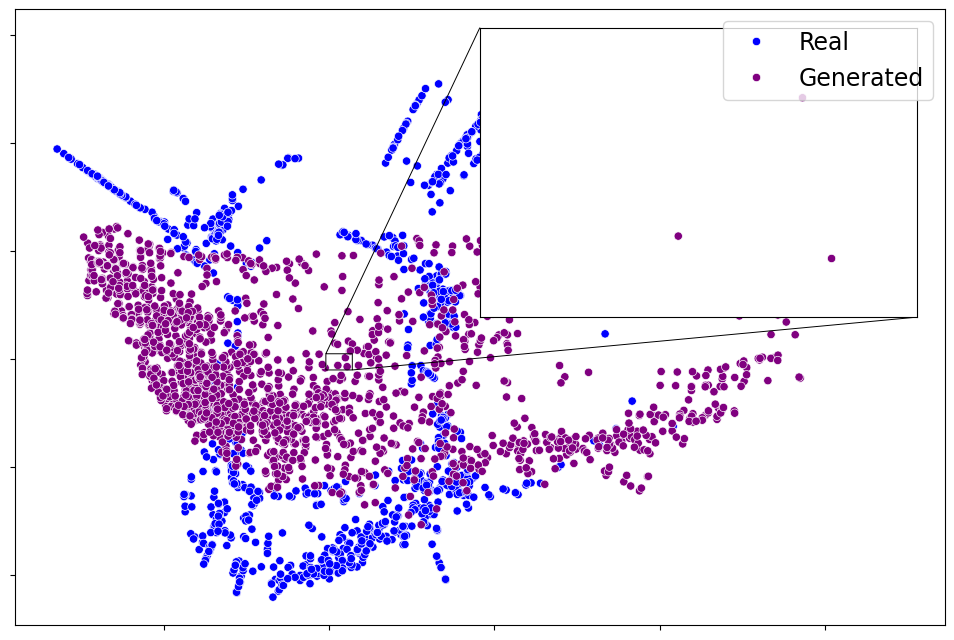

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(
    x=data_transformed[:, 0],
    y=data_transformed[:, 1],
    hue=grouper,
    palette=['blue', 'purple'],
    ax=ax
)
x1, x2, y1, y2 = -1, 7, -2, 1  # subregion of the original image
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# # Add labels from the 'labels' column
# for i, (x, y) in enumerate(data_transformed):
#     plt.text(x, y, i, fontsize=10)



sns.scatterplot(
    x=data_transformed[:, 0],
    y=data_transformed[:, 1],
    hue=grouper,
    palette=['blue', 'purple'],
    ax=axins
)
ax.indicate_inset_zoom(axins,  edgecolor="black", alpha=1,lw=0.7)
axins.get_legend().set_visible(False)

axins.set_xticks([])
axins.set_yticks([])
ax.legend(fontsize=17)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

df_audios = pd.DataFrame(data_transformed, columns=['x', 'y'])
df_audios['num'] = df_audios.index
df_audios['type'] = grouper

fig = px.scatter(df_audios, x="x", y="y", color="type", hover_name='num', color_discrete_sequence=['blue', 'purple', 'red'])

fig.show()


In [ ]:
data_transformed.shape

(3140, 2)

In [ ]:
real_cluster = kmeans.predict(real_data_red)
_mask = np.ones(len(real_data), dtype=bool)
for i in set_to_take:
    _mask = _mask & (real_cluster != i)
_mask.sum()

np.int64(1041)

In [ ]:
set_to_take

(1, 2)

In [ ]:
import pandas as pd
import plotly.express as px

temp_cant = data_transformed.shape[1]
df_audios = pd.DataFrame(data_transformed, columns=['x', 'y', 'z'][:temp_cant])
df_audios['num'] = df_audios.index
df_audios['type'] = grouper
df_audios['group'] = grouper
df_audios.loc[df_audios['type'] ==  'Generated', 'group'] = [f'$S_{i}$'for i in kmeans.labels_]
# df_audios.loc[df_audios['type'] ==  'Real', 'group'] = [f'Real_{i}'for i in real_cluster]
df_audios['paths'] =  real_paths + gen_paths

In [ ]:
fig = px.scatter(df_audios, x="x", y="y", color="type", hover_name='num')

fig.show()

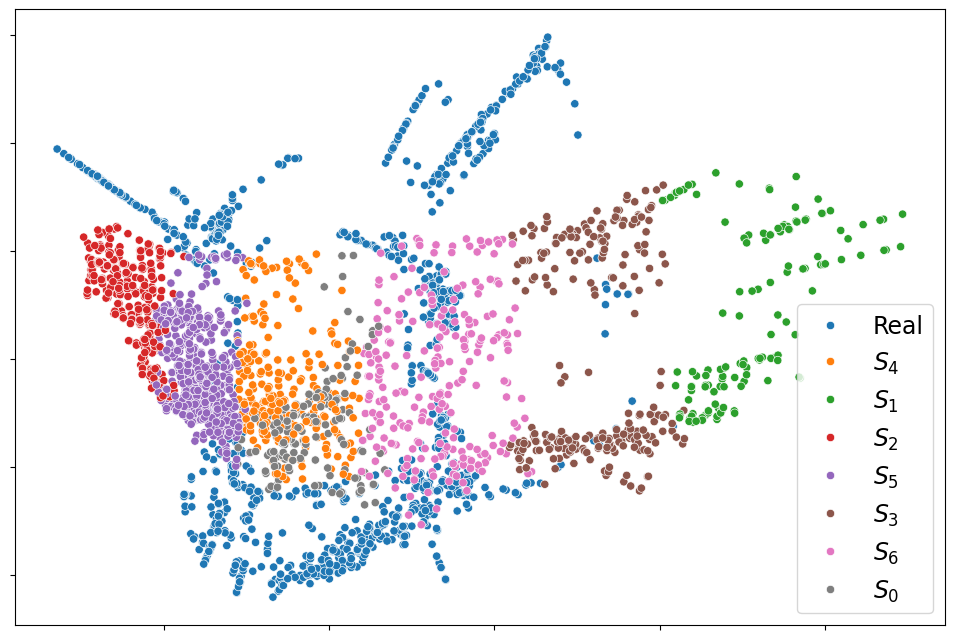

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(data=df_audios, x="x", y="y", hue="group", ax=ax)


axins.set_xticks([])
axins.set_yticks([])
ax.legend(fontsize=17)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()



In [ ]:
import librosa
paths = real_paths + gen_paths
def load_audio(path, verbose=False):
    audio, sr = librosa.load(path, sr=16_000)

    return audio, sr

In [ ]:
paths

['/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1067.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1012.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1015.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/991.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1074.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1004.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/984.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1009.wav',
 '/content/drive/MyDrive/AnuraSoundProject/Systema

In [ ]:
from IPython.display import Audio

load_path = paths[48]
print(load_path)
audio, sr = load_audio(load_path)

Audio(data=audio, rate=16_000)

/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1034.wav


In [ ]:
set_to_take

(1, 2)

# Save database

In [ ]:
to_save = {'Real': [], 'Generado': []}
banned_grups = [f'$S_{i}$' for i in set_to_take]\
      + [f'Real_{i}' for i in set_to_take] + ['Generated_0', "Real_0"]
for i in range(len(paths)):
  root = paths[i]
  row = df_audios.iloc[i]
  real = True if row.type == 'Real' else False
  if row.group in banned_grups :
    continue

  audio, sr = load_audio(root)

  dict_audio = {
      'root': root,
      'real': real,
      'audio': audio,
      'sr': 16_000,
      'mark': []
  }
  if real:
      to_save["Real"].append(dict_audio)
  else:
      to_save["Generado"].append(dict_audio)

In [ ]:
print("Number of good quality samples generated:")
len(to_save['Generado'])

Number of good quality samples generated:


1458

In [ ]:
paths

['/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1067.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1012.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1015.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/991.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1074.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1004.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/984.wav',
 '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_REAL/1009.wav',
 '/content/drive/MyDrive/AnuraSoundProject/Systema

In [ ]:
banned_grups

['$S_1$', '$S_2$', 'Real_1', 'Real_2', 'Generated_0', 'Real_0']

In [ ]:
len(to_save['Generado'])

1457

In [ ]:
to_save['Generado']

[{'root': '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_GENERATED/1230.wav',
  'real': False,
  'audio': array([-3.05175781e-05, -8.23974609e-04, -3.05175781e-04, ...,
         -1.19018555e-02, -1.32751465e-02, -1.06201172e-02], dtype=float32),
  'sr': 16000,
  'mark': []},
 {'root': '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_GENERATED/676.wav',
  'real': False,
  'audio': array([ 0.00036621,  0.00213623,  0.00057983, ...,  0.00030518,
         -0.00064087,  0.00064087], dtype=float32),
  'sr': 16000,
  'mark': []},
 {'root': '/content/drive/MyDrive/AnuraSoundProject/SystematicSelection/4_systematic_selection/embedding/BOAFAB_GENERATED/1507.wav',
  'real': False,
  'audio': array([-0.00045776, -0.00119019,  0.00079346, ..., -0.00024414,
         -0.00112915, -0.00073242], dtype=float32),
  'sr': 16000,
  'mark': []},
 {'root': '/content/drive/MyDrive/AnuraSoundProject/Syst

In [ ]:
import pickle

with open('./audios_to_human_test.pkl', 'wb') as f:
    pickle.dump(to_save, f)